<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [195]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator

#### Función para mostrar lista de imágenes en escala de grises

In [2]:
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

In [111]:
IMG_SIZE = 32

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])


#### Lectura de los datos:

In [95]:
# seed random number generator
seed(1)

# Dimensión de entrada de las imágenes 
h = IMG_SIZE
w = IMG_SIZE


# Leer los nombres de las imágenes para importarlas
input_class1_path = "./Dataset/Grading_dataset/Class_I"
class1_names = os.listdir(input_class1_path)
input_class2_path = "./Dataset/Grading_dataset/Class_II"
class2_names = os.listdir(input_class2_path)
input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
class3_names = os.listdir(input_classex_path)

# Número de elementos en cada clase
n = len(class1_names)

# Definir listas para cargar imágenes
class1 = np.ones([n, h, w, 3])
class2 = np.ones([n, h, w, 3])
class3 = np.ones([n, h, w, 3])



for i in range(0, n, 1):
    # Para cada clase, se lee una imágen, se importa
    img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
    class1[i] = img  
    img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
    class2[i] = img 
    img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
    class3[i] = img 



#### Se muestran una imágen aleatoria de cada clase para comprobar que se leyeron correctamente

158


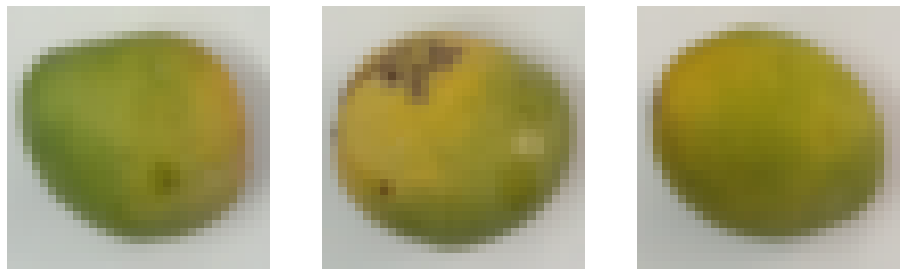

In [105]:
rn = randint(0, 200)
print (rn)
img_1 = class1[rn]
img_2 = class2[rn]
img_3 = class3[rn]    
show_row_of_gray_images(16, img_1, img_2, img_3)

### Aumentamos por un factor f el número de datos de cada clase

In [112]:
f = 10
class1_augmeted = np.zeros([n * f, h, w, 3])
class2_augmeted = np.zeros([n * f, h, w, 3])
class3_augmeted = np.zeros([n * f, h, w, 3])
t1 = np.zeros(n * f)
t2 = np.zeros(n * f)
t3 = np.zeros(n * f)

for i in range(n * f):
    rn = randint(0, n-1)
    img = class1[rn]
    new_img = data_augmentation(img)
    class1_augmeted [i] = new_img
    t1[i] = 1
    
    rn = randint(0, n-1)
    img = class2[rn]
    new_img = data_augmentation(img)
    class2_augmeted [i] = new_img
    t2[i] = 2
    
    rn = randint(0, n-1)
    img = class3[rn]
    new_img = data_augmentation(img)
    class3_augmeted [i] = new_img
    t3[i] = 3


#### Se imprimen tres imágenes para comprobar que las transformaciones han salido bien

478
521
380


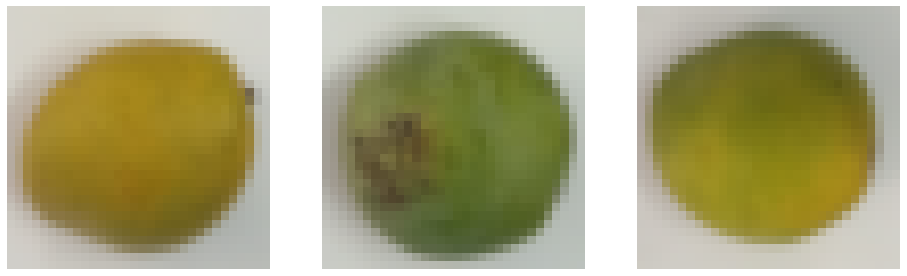

In [114]:
# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
rn = randint(0, 2000)
img_1 = class1_augmeted[rn]
print (rn)
rn = randint(0, 2000)
print (rn)
img_2 = class2_augmeted[rn]
rn = randint(0, 2000)
print (rn)
img_3 = class3_augmeted[rn]  
show_row_of_gray_images(16, img_1, img_2, img_3)

#### Conformación del set de datos y declaración de las métricas de análsis:

In [220]:
CV = 20
# Se define el conjunto de datos de entrenamiento
X = np.zeros([(f-1)*n*3,h*w*3])
X[0:1800] = class3_augmeted[0:1800].reshape((f-1)*n,h*w*3)
X[1800:3600] = class1_augmeted[0:1800].reshape((f-1)*n,h*w*3)
X[3600:5400] = class2_augmeted[0:1800].reshape((f-1)*n,h*w*3)

# extract train and val features
X_train = np.ones([(f-1)*n*3,h,w,3])
X_train[0:1800] = class3_augmeted[0:1800]
X_train[1800:3600] = class1_augmeted[0:1800]
X_train[3600:5400] = class2_augmeted[0:1800]

# Se define el conjunto de datos de validación
X_val = np.zeros([n*3, h, w, 3])
X_val[0:200] = class3_augmeted[1800:2000]
X_val[200:400] = class1_augmeted[1800:2000]
X_val[400:600] = class2_augmeted[1800:2000]
# Se definen las etiquetas de las clases
t = np.zeros((f-1)*n*3)
t[0:1800] = t3[0:1800]
t[1800:3600] = t1[0:1800]
t[3600:5400] = t2[0:1800]
# Se definen las etiquetas de las clases para la validación
t_val = np.zeros(n*3)
t_val[0:200] = t3[1800:2000]
t_val[200:400] = t1[1800:2000]
t_val[400:600] = t2[1800:2000]

scoring = ['recall_macro', 'precision_micro', 'recall_micro', 'f1_macro','accuracy']

#### Validación cruzada con Logistic Regression

In [33]:
modelLR = LogisticRegression(penalty='none', solver = 'lbfgs', max_iter=10000, multi_class='multinomial')
scoresLR = cross_validate(modelLR, X, t, cv=CV, scoring=scoring)
print('Media del LR  : ', np.mean(scoresLR['test_accuracy']))

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Media del LR  :  0.8648148148148147


C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Validación cruzada con LDA

In [75]:
modelLDA = LinearDiscriminantAnalysis()
scoresLDA = cross_validate(modelLDA, X, t, cv=CV, scoring=scoring)
print('Media del LDA : ', np.mean(scoresLDA['test_accuracy']))

Media del LDA :  0.8544444444444442


#### Validación cruzada con KNN

In [116]:
modelKNN = KNeighborsClassifier(round(np.sqrt((f-1)*n)))
scoresKNN = cross_validate(modelKNN, X, t, cv=CV, scoring=scoring)
print('Media del KNN : ', np.mean(scoresKNN['test_accuracy']))

Media del KNN :  0.6916666666666667


#### Validación cruzada con Random Forest

In [117]:
modelRF = RandomForestClassifier(n_estimators=20, criterion='gini')
scoresRF = cross_validate(modelRF, X, t, cv=CV, scoring=scoring)
print('Media del KNN : ', np.mean(scoresRF['test_accuracy']))

Media del KNN :  0.9774074074074072


#### Se importa la red CNN VGG16 para utilizar su arquitectura y conocimento para resolver nuestro problema 

In [118]:
from keras import applications
from keras.models import Sequential
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
# include top should be False to remove the softmax layer
pretrained_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [245]:
X_train, train_target = shuffle(X_train, t, random_state=0)
X_val, val_target = shuffle(X_val, t_val, random_state=0)
# extract train and val features
vgg_features_train = pretrained_model.predict(X_train)
vgg_features_val = pretrained_model.predict(X_val)

In [234]:
# OHE target column)
train_target = tf.keras.utils.to_categorical(train_target)[:,1:4]
val_target = tf.keras.utils.to_categorical(val_target)[:,1:4]

In [235]:
modelCNN = Sequential()
modelCNN.add(Flatten(input_shape=(1,1,512)))
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(3, activation='softmax'))
# compile the model
modelCNN.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
modelCNN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               51300     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 3)                 303       
                                                                 
Total params: 52,003
Trainable params: 51,803
Non-trainable params: 200
_______________________________________________

In [237]:
# train model using features generated from VGG16 model
history = (modelCNN.fit(vgg_features_train, train_target, epochs=100, batch_size=50, validation_data=(vgg_features_val, val_target)))

Epoch 1/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1379 - accuracy: 0.3428 - val_loss: 1.1003 - val_accuracy: 0.3383
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1158 - accuracy: 0.3293 - val_loss: 1.0985 - val_accuracy: 0.3417
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1076 - accuracy: 0.3328 - val_loss: 1.0979 - val_accuracy: 0.3833
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 1.1009 - accuracy: 0.3485 - val_loss: 1.0982 - val_accuracy: 0.3783
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1012 - accuracy: 0.3319 - val_loss: 1.0980 - val_accuracy: 0.3550
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1012 - accuracy: 0.3393 - val_loss: 1.0979 - val_accuracy: 0.3450
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1017 - accuracy: 0.3267 - val_loss: 1.0977 - val_accuracy: 0.3750

In [238]:

modelCNN2 = models.Sequential()
modelCNN2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
modelCNN2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelCNN2.add(layers.MaxPooling2D((2, 2)))
modelCNN2.add(layers.Dropout(0.2))
modelCNN2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelCNN2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelCNN2.add(layers.MaxPooling2D((2, 2)))
modelCNN2.add(layers.Dropout(0.2))
modelCNN2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelCNN2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelCNN2.add(layers.MaxPooling2D((2, 2)))
modelCNN2.add(layers.Dropout(0.2))
modelCNN2.add(layers.Flatten())
modelCNN2.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelCNN2.add(layers.Dropout(0.2))
modelCNN2.add(layers.Dense(3))
opt = keras.optimizers.Adam(learning_rate=0.001) 
modelCNN2.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
modelCNN2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [252]:
print (X_train.shape)
t_traint = train_target - 1
t_val = val_target - 1
tt = tf.keras.utils.to_categorical(train_target)
vt = tf.keras.utils.to_categorical(t_val)
modelCNN2.fit(X_train, tt, epochs=100, batch_size=50, validation_data=(X_val, vt))

(5400, 32, 32, 3)
Epoch 1/100


TypeError: 'NoneType' object is not callable

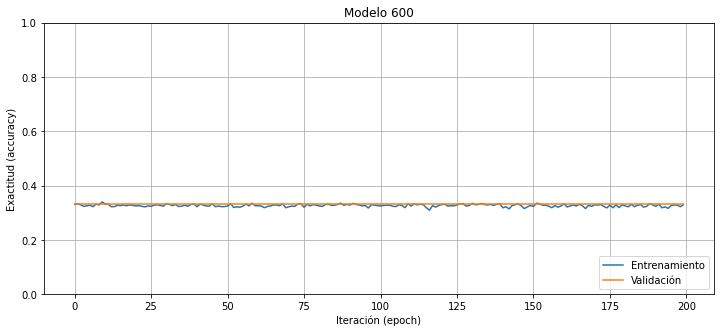

In [227]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label = 'Validación')
plt.xlabel('Iteración (epoch)')
plt.ylabel('Exactitud (accuracy)')
plt.ylim([0, 1])
plt.grid()
plt.title('Modelo '+str(i+1))
plt.legend(loc='lower right')

In [192]:
vgg_features_test = pretrained_model.predict(X_val)
test_loss, test_acc = modelCNN.evaluate(vgg_features_test,  val_target, verbose=0)
print('Accuray (test)', test_acc)

Accuray (test) 0.8550000190734863


El conjunto de entrenamiento contiene 3779 datos
El conjunto de test contiene 1621 datos


Text(0, 0.5, 'Clase real')

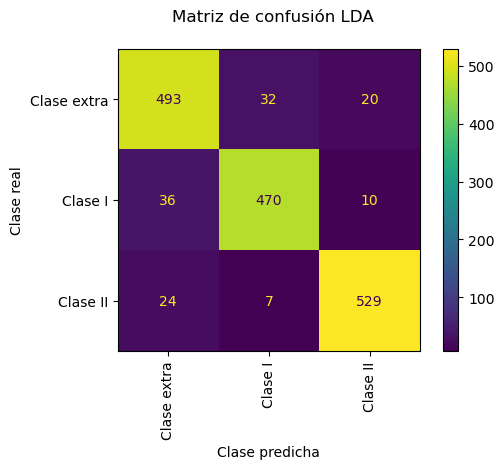

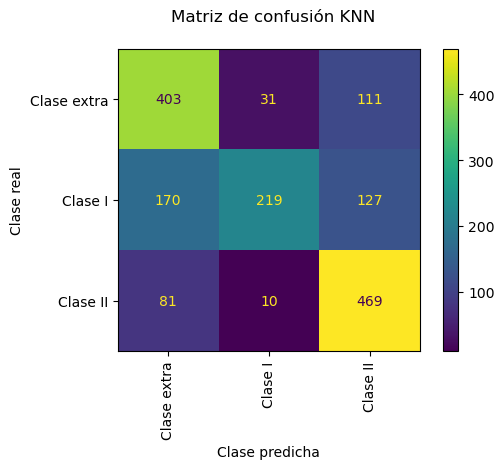

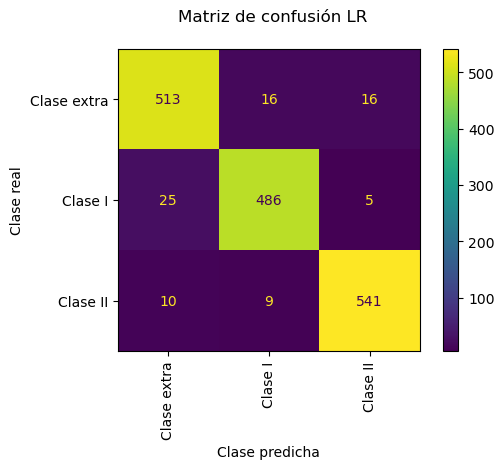

In [185]:
Clases=['Clase extra','Clase I','Clase II']
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7)  
print("El conjunto de entrenamiento contiene", len(t_train), "datos")
print("El conjunto de test contiene", len(t_test), "datos")

modelLDA.fit(X_train, t_train)
disp = plot_confusion_matrix(modelLDA, X_test, t_test, display_labels = Clases, xticks_rotation = 'vertical') # Muestra gráficamente la matriz de confusión
disp.figure_.suptitle("Matriz de confusión LDA");         # Añade un título a la figura de la matriz de confusión
disp.figure_.set_dpi(100)                             # Establece el tamaño de la figura
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

modelKNN.fit(X_train, t_train)
disp = plot_confusion_matrix(modelKNN, X_test, t_test, display_labels = Clases, xticks_rotation = 'vertical') # Muestra gráficamente la matriz de confusión
disp.figure_.suptitle("Matriz de confusión KNN");         # Añade un título a la figura de la matriz de confusión
disp.figure_.set_dpi(100)                             # Establece el tamaño de la figura
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

modelRF.fit(X_train, t_train)
disp = plot_confusion_matrix(modelRF, X_test, t_test, display_labels = Clases, xticks_rotation = 'vertical') # Muestra gráficamente la matriz de confusión
disp.figure_.suptitle("Matriz de confusión LR");         # Añade un título a la figura de la matriz de confusión
disp.figure_.set_dpi(100)                             # Establece el tamaño de la figura
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

In [204]:
X_test, t_test = shuffle(X_val, t_val, random_state=0)
vgg_features_test = pretrained_model.predict(X_test)

In [210]:
t_pred = []
for i in range(0,len(vgg_features_test)):
    t_pred.append(np.argmax(modelCNN.predict(vgg_features_test[i:i+1])))

In [214]:
tf.math.confusion_matrix(t_test, t_pred)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[  0,   0,   0,   0],
       [132,  29,  39,   0],
       [ 11, 186,   3,   0],
       [  5,   0, 195,   0]])>

#### Se muestra un diagrama de cajas con los resultados de la validación cruzada:

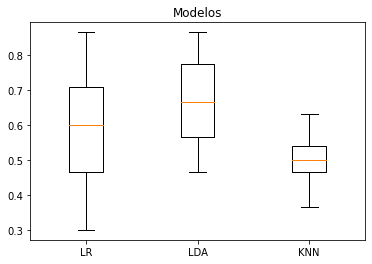

In [82]:
data = [scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy']]
fig7, ax = plt.subplots()
ax.set_title('Modelos')
ax.boxplot(data,labels=['LR', 'LDA', 'KNN']);

#### Contraste de hipótesis:

Primero se muestran los resultados obtenidos aplicando el test de [Kruskall-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) y el test de [Anova](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). Si se rechaza la hipótesis, entonces se puede afirmar que los modelos son diferentes y, posteriormente, se aplican dos test de comparación múltiple mediante el uso de la clase [MultiComparison](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html). Estos métodos comprueban si hay diferencias significativas con un p<0.05, corrigiendo el hecho de que se están haciendo múltiples comparaciones que normalmente aumentarían la probabilidad de que se identifique una diferencia significativa. Un resultado de "reject = true" significa que se ha observado una diferencia significativa:
- Método de Tukey. Se emplea para ello la función [tukeyhsd](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd.html#statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd).
- Método de Holm-Bonferroni. Se emplea para ello la función [allpairtest](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest)

In [83]:
alpha = 0.05
F_statistic, pVal = stats.kruskal(scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy'])
F_statistic2, pVal2 = stats.f_oneway(scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy'])
print ('p-valor KrusW:', pVal)
print ('p-valor ANOVA:', pVal2)
if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')
    stacked_data = np.vstack((scoresLR['test_accuracy'],scoresLDA['test_accuracy'],scoresKNN['test_accuracy'])).ravel()
    stacked_model = np.vstack((np.repeat('modelLR',CV),np.repeat('modelLDA',CV),np.repeat('modelKNN',CV))).ravel()    
    MultiComp = MultiComparison(stacked_data, stacked_model)
    comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm')
    print (comp[0])    
    print(MultiComp.tukeyhsd(alpha=0.05))
else:
    print('Aceptamos la hipótesis: los modelos son iguales')

p-valor KrusW: 0.00042614900422063547
p-valor ANOVA: 0.00021999310037581105
Rechazamos la hipótesis: los modelos son diferentes

Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.02, alphacBonf=0.017
 group1   group2    stat   pval  pval_corr reject
-------------------------------------------------
modelKNN modelLDA -8.7529    0.0       0.0   True
modelKNN  modelLR -3.7438 0.0014    0.0014   True
modelLDA  modelLR  4.2041 0.0005     0.001   True
-------------------------------------------------
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
modelKNN modelLDA   0.1667  0.001  0.0755 0.2579   True
modelKNN  modelLR      0.1 0.0285  0.0088 0.1912   True
modelLDA  modelLR  -0.0667 0.1927 -0.1579 0.0245  False
-------------------------------------------------------
